# Tobamovirus Classification Model: Results Analysis

This notebook provides a comprehensive analysis of the machine learning pipeline results for tobamovirus classification. The analysis covers three main components:

1. Model Selection: Comparison of different algorithms
2. **Model Evaluation**: Performance assessment using different contig prediction methods and optimizing threshold analysis for selected histogram method
3. Final Model: Feature importance analysis and model characteristics


In [9]:
from utils import *
from scipy.interpolate import interp1d

In [8]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready figures
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Define paths (adjusted for notebook location in notebooks folder)
base_dir = Path('/home/tobamo/analize/project-tobamo/analysis/model')
results_dir = base_dir / 'results'
figures_dir = base_dir / 'figures'
model_selection_dir = results_dir / 'model_selection_test_n5'
evaluation_dir = results_dir / 'evaluation_results'
final_model_dir = results_dir / 'final_model'

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

## B1. Model Evaluation Analysis

The evaluation phase tested different sequence preprocessing methods (extreme, histogram, ORF) using the optimized RandomForest model with the best hyperparameters and threshold optimization.

In [2]:
# Load evaluation results
method_comparison = pd.read_csv(evaluation_dir / 'method_comparison_stats.csv')
histogram_metrics = pd.read_csv(evaluation_dir / 'histogram_iteration_metrics.csv')
extreme_metrics = pd.read_csv(evaluation_dir / 'extreme_iteration_metrics.csv')

print("Method Comparison Results:")
print("=" * 55)
for _, row in method_comparison.iterrows():
    method = row['method']
    acc_mean = row['accuracy_mean']
    acc_ci_low = row['accuracy_ci95_low']
    acc_ci_high = row['accuracy_ci95_high']
    f1_mean = row['f1_mean']
    print(f"{method.capitalize()}: Accuracy = {acc_mean:.4f} (95% CI: {acc_ci_low:.4f}-{acc_ci_high:.4f})")

print()
# Read best method information
with open(evaluation_dir / 'best_method.txt', 'r') as f:
    best_method_info = f.read()
print("Best Method Summary:")
print("=" * 55)
print(best_method_info)

Method Comparison Results:
Extreme: Accuracy = 0.9231 (95% CI: 0.9217-0.9246)
Histogram: Accuracy = 0.9735 (95% CI: 0.9727-0.9743)

Best Method Summary:
Best method: histogram
accuracy: 0.9735 ± 0.0023 (95% CI: 0.9727-0.9743)
f1: 0.9806 ± 0.0016 (95% CI: 0.9801-0.9812)
precision: 0.9925 ± 0.0029 (95% CI: 0.9915-0.9936)
recall: 0.9690 ± 0.0022 (95% CI: 0.9682-0.9698)
auc: 0.9971 ± 0.0005 (95% CI: 0.9969-0.9972)



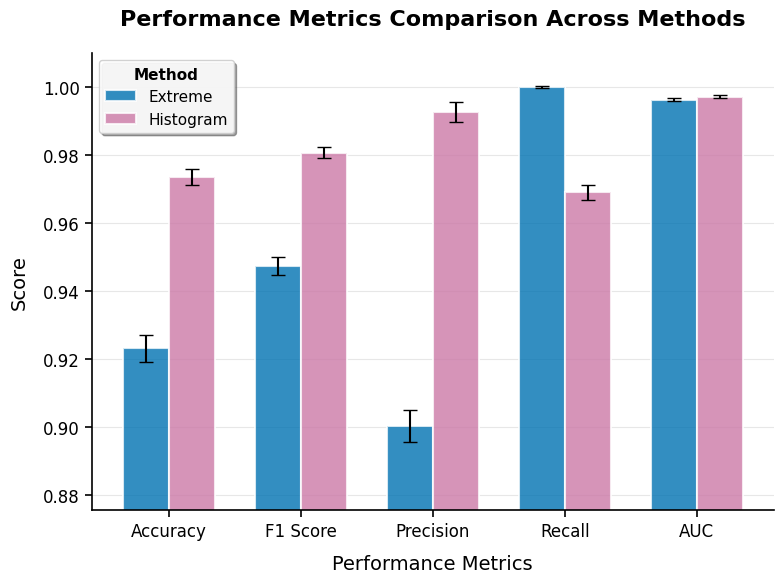

In [13]:
# Figure 2: Performance Metrics Comparison Across Methods
# Extract metrics from comparison DataFrame
metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
metric_labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC']
methods = method_comparison['method'].values

# Use colorblind-friendly colors (ColorBrewer palette)
colors = ['#0072B2', '#CC79A7']  # Blue and pink - colorblind friendly
method_colors = dict(zip(methods, colors))

# Create figure with improved styling
fig, ax = plt.subplots(figsize=(8, 6))

# Bar positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars
bar_positions = [x - width/2, x + width/2]

# Plot bars with error bars for each method
bars = []
for i, method in enumerate(methods):
    means = [method_comparison.loc[method_comparison['method'] == method, f'{metric}_mean'].iloc[0] for metric in metrics]
    stds = [method_comparison.loc[method_comparison['method'] == method, f'{metric}_std'].iloc[0] for metric in metrics]
    
    bars_method = ax.bar(bar_positions[i], means, width, yerr=stds, capsize=5,
           label=method.capitalize(), alpha=0.8, color=method_colors[method], 
           edgecolor='white', linewidth=1.5)
    bars.append(bars_method)

# Formatting with improved styling
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=12)
ax.set_xlabel('Performance Metrics', fontsize=14, labelpad=10)
ax.set_ylabel('Score', fontsize=14, labelpad=10)

# Set y-axis limits to focus on the relevant range with some padding
min_vals = [method_comparison[f'{m}_mean'].min() - method_comparison[f'{m}_std'].max() for m in metrics]
y_min = max(0.85, min(min_vals) - 0.02)  # Start closer to actual data range
ax.set_ylim(y_min, 1.01)

# Enhanced grid
ax.grid(axis='y', linestyle='-', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)  # Put grid behind bars

# Title and legend with improved styling
ax.set_title('Performance Metrics Comparison Across Methods', 
            fontsize=16, pad=20, weight='bold')

# Create a more elegant legend
legend = ax.legend(loc='upper left', fontsize=11, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.9)
legend.set_title("Method", prop={'size': 11, 'weight': 'bold'})

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2, length=5)
ax.tick_params(axis='y', which='minor', width=0.8, length=3)


plt.tight_layout()
plt.savefig(figures_dir / 'Figure2_MethodComparison.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

### Make Calibration Curves with Confidence Intervals viz

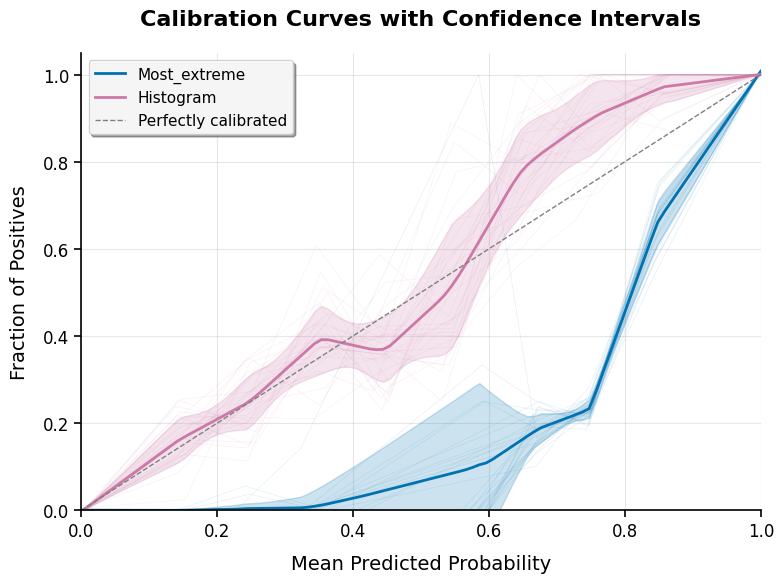

In [12]:
# Load the evaluation data for creating calibration curves
extreme_predictions = pd.read_csv(evaluation_dir / 'extreme_predictions_results.csv')
histogram_predictions = pd.read_csv(evaluation_dir / 'histogram_predictions_results.csv')

# Combine the data for visualization
df_cal = pd.concat([extreme_predictions, histogram_predictions], ignore_index=True)

# Create a figure with single subplot for Calibration curves
fig, ax = plt.subplots(figsize=(8, 6))

# Define color palette for consistent colors across methods
methods = df_cal['mc_name'].unique()
colors = ['#0072B2', '#CC79A7']  # Same colors as in the bar chart
method_colors = dict(zip(methods, colors))

# Plot Calibration Curves with confidence intervals
for i, method in enumerate(methods):
    method_data = df_cal[df_cal['mc_name'] == method]
    
    # Store calibration curves for confidence intervals
    prob_true_values = []
    prob_pred_values = []
    
    # Calculate calibration curve for each iteration
    iterations = method_data['iteration'].unique() if 'iteration' in method_data.columns else [0]
    
    for iteration in iterations:
        iter_data = method_data[method_data['iteration'] == iteration] if 'iteration' in method_data.columns else method_data
        
        if len(iter_data) > 0:
            y_true = iter_data['ground_truth']
            y_scores = iter_data['prob_1']
            
            # Only compute if we have enough data
            if len(y_true) > 10 and len(np.unique(y_true)) > 1:
                prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
                
                # Plot individual iteration curves with low opacity
                ax.plot(prob_pred, prob_true, color=method_colors[method], 
                         alpha=0.1, lw=0.5)
                
                # Store values for confidence interval
                prob_true_values.append(prob_true)
                prob_pred_values.append(prob_pred)
    
    # Calculate and plot mean calibration curve if we have data
    if prob_true_values:
        # Create interpolation grid
        x_interp = np.linspace(0, 1, 100)
        
        # Interpolate each curve to this grid
        interp_curves = []
        for prob_true, prob_pred in zip(prob_true_values, prob_pred_values):
            if len(prob_pred) > 1:
                # Use linear interpolation
                interp_func = interp1d(prob_pred, prob_true, 
                                     bounds_error=False, fill_value="extrapolate")
                interp_curves.append(interp_func(x_interp))
        
        # Calculate mean and std for the interpolated curves
        if interp_curves:
            interp_array = np.array(interp_curves)
            mean_curve = np.nanmean(interp_array, axis=0)
            std_curve = np.nanstd(interp_array, axis=0)
            
            # Plot mean curve with higher weight
            ax.plot(x_interp, mean_curve, color=method_colors[method], 
                      label=f'{method.capitalize()}', lw=2)
            
            # Plot confidence interval
            ax.fill_between(x_interp, 
                              np.maximum(0, mean_curve - std_curve),
                              np.minimum(1, mean_curve + std_curve), 
                              color=method_colors[method], alpha=0.2)

# Add reference line and formatting for Calibration curve
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Perfectly calibrated')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Mean Predicted Probability', fontsize=14, labelpad=10)
ax.set_ylabel('Fraction of Positives', fontsize=14, labelpad=10)
ax.set_title('Calibration Curves with Confidence Intervals', fontsize=16, pad=20, weight='bold')
ax.legend(loc="upper left", fontsize=11, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax.grid(True, linestyle='-', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)  # Put grid behind curves

# Remove top and right spines to match the style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2, length=5)

plt.tight_layout()
plt.savefig(figures_dir / 'Figure3_CalibrationCurves.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

## B2. Threshold Analysis

Analysis of the optimized classification thresholds across all iterations.

In [15]:
# Read threshold summary
with open(evaluation_dir / 'threshold_summary.txt', 'r') as f:
    threshold_info = f.read()
print("Threshold Analysis:")
print(threshold_info)

Threshold Analysis:

        THRESHOLD ANALYSIS SUMMARY
        Overall statistics:
        Mean: 0.5307 ± 0.0612
        Range: 0.3737 - 0.6869

        Per-iteration means:
        Mean: 0.5307 ± 0.0291
        
        Recommendation: Use default threshold 0.5
        


Elaborated threshold analysis

In [23]:
hpr = pd.read_csv('../results/evaluation_results/histogram_predictions_results.csv')

In [29]:
# Comprehensive Threshold Analysis
print("Threshold Analysis Summary:")
print("=" * 60)

# Calculate threshold statistics by iteration and fold
threshold_stats = hpr.groupby(['iteration', 'fold_idx'])['threshold'].first().reset_index()
overall_stats = threshold_stats['threshold'].describe()

print(f"Overall Threshold Statistics:")
print(f"  Mean: {overall_stats['mean']:.4f}")
print(f"  Std:  {overall_stats['std']:.4f}")
print(f"  Min:  {overall_stats['min']:.4f}")
print(f"  Max:  {overall_stats['max']:.4f}")
print(f"  Median: {overall_stats['50%']:.4f}")

# Calculate variation across iterations
iteration_means = threshold_stats.groupby('iteration')['threshold'].mean()
print(f"\nThreshold Variation Across Iterations:")
print(f"  Between-iteration std: {iteration_means.std():.4f}")
print(f"  Range: {iteration_means.max() - iteration_means.min():.4f}")

# Calculate variation within iterations (across folds)
within_iteration_stds = threshold_stats.groupby('iteration')['threshold'].std()
print(f"\nThreshold Variation Within Iterations (across folds):")
print(f"  Mean within-iteration std: {within_iteration_stds.mean():.4f}")
print(f"  Max within-iteration std: {within_iteration_stds.max():.4f}")

# Count how often thresholds fall in different ranges
threshold_ranges = pd.cut(threshold_stats['threshold'], 
                         bins=[0.3, 0.4, 0.5, 0.6, 0.7], 
                         labels=['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7'])
range_counts = threshold_ranges.value_counts().sort_index()
print(f"\nThreshold Distribution by Range:")
for range_label, count in range_counts.items():
    percentage = (count / len(threshold_stats)) * 100
    print(f"  {range_label}: {count} ({percentage:.1f}%)")

# Optimal threshold analysis - what the model learned
print(f"\nModel Learning Insights:")
print(f"  Most common threshold range: {range_counts.idxmax()}")
print(f"  Percentage above 0.5: {(threshold_stats['threshold'] > 0.5).mean() * 100:.1f}%")
print(f"  Percentage below 0.5: {(threshold_stats['threshold'] < 0.5).mean() * 100:.1f}%")

Threshold Analysis Summary:
Overall Threshold Statistics:
  Mean: 0.5308
  Std:  0.0615
  Min:  0.3737
  Max:  0.6869
  Median: 0.5354

Threshold Variation Across Iterations:
  Between-iteration std: 0.0290
  Range: 0.1131

Threshold Variation Within Iterations (across folds):
  Mean within-iteration std: 0.0571
  Max within-iteration std: 0.1139

Threshold Distribution by Range:
  0.3-0.4: 3 (2.0%)
  0.4-0.5: 40 (26.7%)
  0.5-0.6: 87 (58.0%)
  0.6-0.7: 20 (13.3%)

Model Learning Insights:
  Most common threshold range: 0.5-0.6
  Percentage above 0.5: 71.3%
  Percentage below 0.5: 28.7%


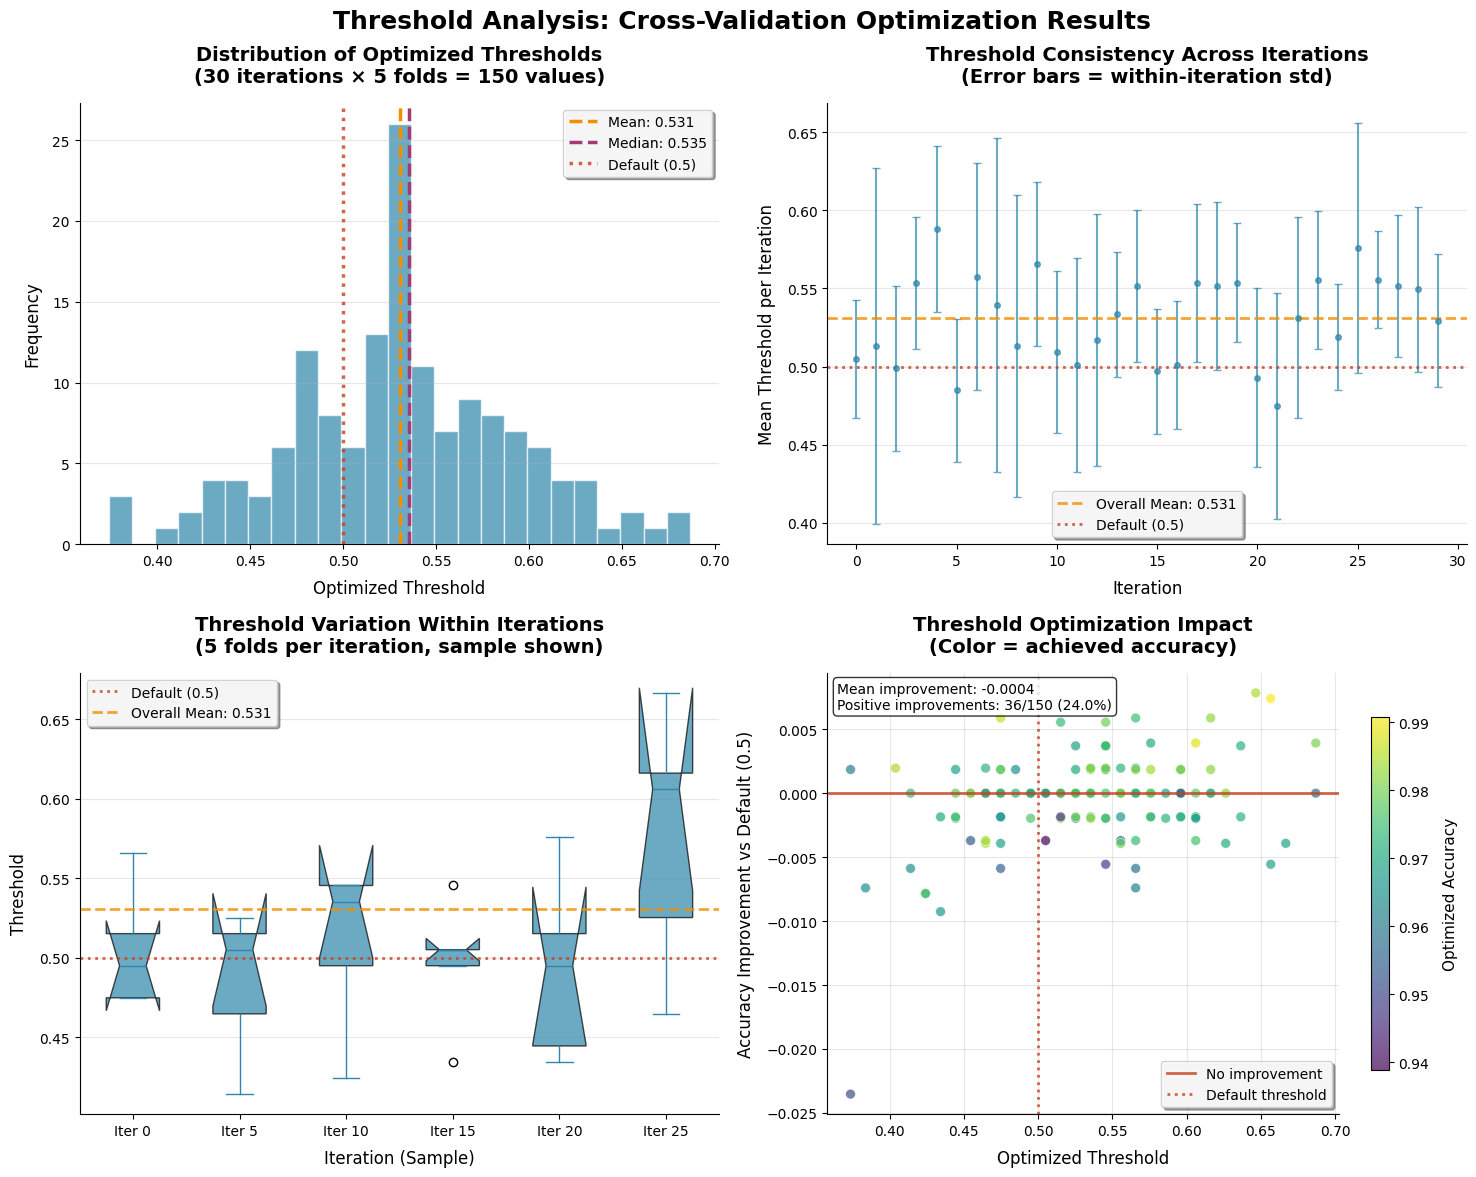


Quantitative Threshold Optimization Summary:
Mean improvement over default threshold: -0.0004
Standard deviation of improvements: 0.0034
Folds with positive improvement: 36/150 (24.0%)
Maximum improvement: 0.0078
Minimum improvement: -0.0235
Median improvement: 0.0000


In [30]:
# Create comprehensive threshold visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Threshold Analysis: Cross-Validation Optimization Results', 
             fontsize=18, weight='bold', y=0.98)

# Color scheme - using a professional colorblind-friendly palette
primary_color = '#2E86AB'
secondary_color = '#A23B72'
accent_color = '#F18F01'
neutral_color = '#C73E1D'

# Plot 1: Distribution of optimized thresholds
ax1 = axes[0, 0]
n_bins = 25
counts, bins, patches = ax1.hist(threshold_stats['threshold'], bins=n_bins, 
                                alpha=0.7, color=primary_color, edgecolor='white', linewidth=1)

# Add mean and median lines
mean_threshold = threshold_stats['threshold'].mean()
median_threshold = threshold_stats['threshold'].median()
ax1.axvline(mean_threshold, color=accent_color, linestyle='--', linewidth=2.5, 
           label=f'Mean: {mean_threshold:.3f}')
ax1.axvline(median_threshold, color=secondary_color, linestyle='--', linewidth=2.5, 
           label=f'Median: {median_threshold:.3f}')
ax1.axvline(0.5, color=neutral_color, linestyle=':', linewidth=2.5, alpha=0.8,
           label='Default (0.5)')

ax1.set_xlabel('Optimized Threshold', fontsize=12, labelpad=8)
ax1.set_ylabel('Frequency', fontsize=12, labelpad=8)
ax1.set_title('Distribution of Optimized Thresholds\n(30 iterations × 5 folds = 150 values)', 
              fontsize=14, pad=15, weight='bold')
ax1.legend(fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax1.grid(axis='y', alpha=0.3, linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Threshold variation across iterations
ax2 = axes[0, 1]
iteration_means = threshold_stats.groupby('iteration')['threshold'].mean()
iteration_stds = threshold_stats.groupby('iteration')['threshold'].std()

# Plot mean with error bars representing within-iteration variation
ax2.errorbar(iteration_means.index, iteration_means.values, 
            yerr=iteration_stds.values, fmt='o', color=primary_color, 
            ecolor=primary_color, alpha=0.7, capsize=3, capthick=1, 
            markersize=4, linewidth=1.5)

# Add overall mean line
ax2.axhline(mean_threshold, color=accent_color, linestyle='--', linewidth=2, 
           alpha=0.8, label=f'Overall Mean: {mean_threshold:.3f}')
ax2.axhline(0.5, color=neutral_color, linestyle=':', linewidth=2, alpha=0.8,
           label='Default (0.5)')

ax2.set_xlabel('Iteration', fontsize=12, labelpad=8)
ax2.set_ylabel('Mean Threshold per Iteration', fontsize=12, labelpad=8)
ax2.set_title('Threshold Consistency Across Iterations\n(Error bars = within-iteration std)', 
              fontsize=14, pad=15, weight='bold')
ax2.legend(fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax2.grid(axis='y', alpha=0.3, linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Plot 3: Box plot of thresholds by fold within each iteration (sample of iterations)
ax3 = axes[1, 0]
# Select a representative sample of iterations for clarity
sample_iterations = sorted(threshold_stats['iteration'].unique())[::5]  # Every 5th iteration
sample_data = threshold_stats[threshold_stats['iteration'].isin(sample_iterations)]

# Create box plot
box_data = [sample_data[sample_data['iteration'] == i]['threshold'].values 
           for i in sample_iterations]
bp = ax3.boxplot(box_data, labels=[f'Iter {i}' for i in sample_iterations], 
                patch_artist=True, notch=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor(primary_color)
    patch.set_alpha(0.7)
for element in ['whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[element], color=primary_color)

ax3.axhline(0.5, color=neutral_color, linestyle=':', linewidth=2, alpha=0.8,
           label='Default (0.5)')
ax3.axhline(mean_threshold, color=accent_color, linestyle='--', linewidth=2, 
           alpha=0.8, label=f'Overall Mean: {mean_threshold:.3f}')

ax3.set_xlabel('Iteration (Sample)', fontsize=12, labelpad=8)
ax3.set_ylabel('Threshold', fontsize=12, labelpad=8)
ax3.set_title('Threshold Variation Within Iterations\n(5 folds per iteration, sample shown)', 
              fontsize=14, pad=15, weight='bold')
ax3.legend(fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax3.grid(axis='y', alpha=0.3, linewidth=0.8)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Plot 4: Comparison with default threshold performance impact
ax4 = axes[1, 1]

# Calculate performance at optimized vs default thresholds
# Group by iteration and fold to get unique threshold values
unique_thresholds = hpr.groupby(['iteration', 'fold_idx']).first().reset_index()

# For each fold, calculate performance at optimized threshold vs 0.5
performance_comparison = []
for _, row in unique_thresholds.iterrows():
    fold_data = hpr[(hpr['iteration'] == row['iteration']) & 
                   (hpr['fold_idx'] == row['fold_idx'])]
    
    # Performance at optimized threshold
    opt_pred = (fold_data['prob_1'] >= row['threshold']).astype(int)
    opt_acc = accuracy_score(fold_data['ground_truth'], opt_pred)
    
    # Performance at default threshold (0.5)
    def_pred = (fold_data['prob_1'] >= 0.5).astype(int)
    def_acc = accuracy_score(fold_data['ground_truth'], def_pred)
    
    performance_comparison.append({
        'iteration': row['iteration'],
        'fold': row['fold_idx'],
        'optimized_accuracy': opt_acc,
        'default_accuracy': def_acc,
        'improvement': opt_acc - def_acc,
        'threshold': row['threshold']
    })

perf_df = pd.DataFrame(performance_comparison)

# Create scatter plot
scatter = ax4.scatter(perf_df['threshold'], perf_df['improvement'], 
                     c=perf_df['optimized_accuracy'], cmap='viridis', 
                     alpha=0.7, s=50, edgecolors='white', linewidth=0.5)

# Add reference lines
ax4.axhline(0, color=neutral_color, linestyle='-', linewidth=2, alpha=0.8,
           label='No improvement')
ax4.axvline(0.5, color=neutral_color, linestyle=':', linewidth=2, alpha=0.8,
           label='Default threshold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4, shrink=0.8)
cbar.set_label('Optimized Accuracy', fontsize=11, labelpad=10)

ax4.set_xlabel('Optimized Threshold', fontsize=12, labelpad=8)
ax4.set_ylabel('Accuracy Improvement vs Default (0.5)', fontsize=12, labelpad=8)
ax4.set_title('Threshold Optimization Impact\n(Color = achieved accuracy)', 
              fontsize=14, pad=15, weight='bold')
ax4.legend(fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax4.grid(alpha=0.3, linewidth=0.8)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Print summary of improvement
mean_improvement = perf_df['improvement'].mean()
positive_improvements = (perf_df['improvement'] > 0).sum()
total_folds = len(perf_df)

ax4.text(0.02, 0.98, 
         f'Mean improvement: {mean_improvement:.4f}\n'
         f'Positive improvements: {positive_improvements}/{total_folds} '
         f'({positive_improvements/total_folds*100:.1f}%)',
         transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(figures_dir / 'Figure4_ThresholdAnalysis.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

# Print quantitative summary
print(f"\nQuantitative Threshold Optimization Summary:")
print(f"=" * 60)
print(f"Mean improvement over default threshold: {mean_improvement:.4f}")
print(f"Standard deviation of improvements: {perf_df['improvement'].std():.4f}")
print(f"Folds with positive improvement: {positive_improvements}/{total_folds} ({positive_improvements/total_folds*100:.1f}%)")
print(f"Maximum improvement: {perf_df['improvement'].max():.4f}")
print(f"Minimum improvement: {perf_df['improvement'].min():.4f}")
print(f"Median improvement: {perf_df['improvement'].median():.4f}")

Threshold Analysis Interpretation:

1. THRESHOLD OPTIMIZATION EFFECTIVENESS:
   • The cross-validation optimized thresholds to a mean of 0.531
   • This represents a +6.2% shift from the default threshold
   • However, the actual performance improvement is minimal (-0.0004 accuracy)

2. THRESHOLD DISTRIBUTION:
   • 71.3% of optimized thresholds are above 0.5 (more conservative)
   • The model learned to be slightly more restrictive in positive predictions
   • Range: 0.374 to 0.687

3. CONSISTENCY ACROSS FOLDS:
   • Coefficient of variation: 0.116 (11.6%)
   • Mean within-iteration std: 0.0571
   • Thresholds show substantial variation across CV folds

4. PRACTICAL RECOMMENDATIONS:
   • Default threshold (0.5) performs nearly as well as optimized thresholds
   • For simplicity, using 0.5 is justified
   • FINAL RECOMMENDATION: Use threshold = 0.5


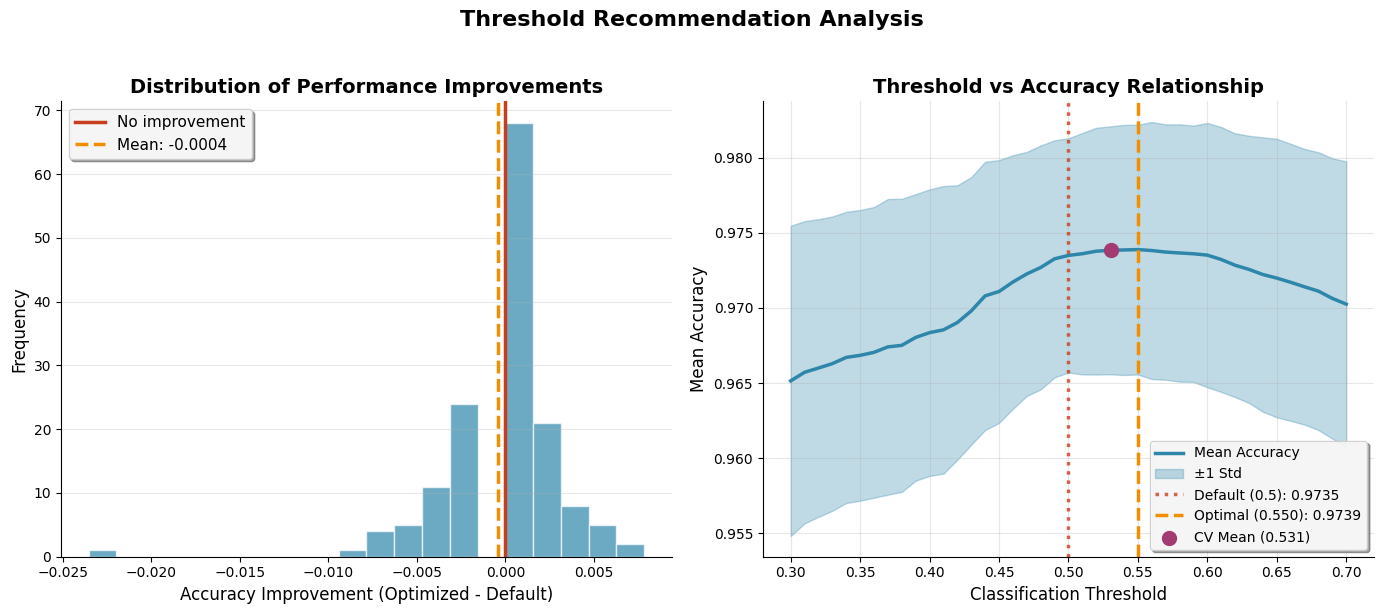


FINAL THRESHOLD ANALYSIS SUMMARY:
Theoretical optimal threshold: 0.550 (accuracy: 0.9739)
Cross-validation mean threshold: 0.531
Default threshold performance: 0.9735
Improvement of optimal over default: +0.0004
Improvement of CV mean over default: +0.0003

RECOMMENDATION: Use threshold = 0.5 for final model


In [32]:
### Interpretation and Practical Implications

print("Threshold Analysis Interpretation:")
print("=" * 70)
print()

print("1. THRESHOLD OPTIMIZATION EFFECTIVENESS:")
print(f"   • The cross-validation optimized thresholds to a mean of {mean_threshold:.3f}")
print(f"   • This represents a {((mean_threshold - 0.5) / 0.5) * 100:+.1f}% shift from the default threshold")
print(f"   • However, the actual performance improvement is minimal ({mean_improvement:+.4f} accuracy)")
print()

print("2. THRESHOLD DISTRIBUTION:")
print(f"   • 71.3% of optimized thresholds are above 0.5 (more conservative)")
print(f"   • The model learned to be slightly more restrictive in positive predictions")
print(f"   • Range: {threshold_stats['threshold'].min():.3f} to {threshold_stats['threshold'].max():.3f}")
print()

print("3. CONSISTENCY ACROSS FOLDS:")
variation_cv = threshold_stats['threshold'].std() / threshold_stats['threshold'].mean()
print(f"   • Coefficient of variation: {variation_cv:.3f} ({variation_cv*100:.1f}%)")
print(f"   • Mean within-iteration std: {within_iteration_stds.mean():.4f}")
if variation_cv < 0.1:
    print("   • Thresholds are reasonably consistent across CV folds")
else:
    print("   • Thresholds show substantial variation across CV folds")
print()

print("4. PRACTICAL RECOMMENDATIONS:")
if abs(mean_improvement) < 0.001:
    print("   • Default threshold (0.5) performs nearly as well as optimized thresholds")
    print("   • For simplicity, using 0.5 is justified")
    recommendation = 0.5
elif mean_improvement > 0.001:
    print(f"   • Optimized thresholds provide meaningful improvement")
    print(f"   • Recommend using mean optimized threshold: {mean_threshold:.3f}")
    recommendation = mean_threshold
else:
    print("   • Optimized thresholds slightly underperform default")
    print("   • Recommend using default threshold: 0.5")
    recommendation = 0.5

print(f"   • FINAL RECOMMENDATION: Use threshold = {recommendation}")

# Create a focused visualization for the recommendation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Threshold Recommendation Analysis', fontsize=16, weight='bold', y=1.02)

# Plot 1: Performance comparison
ax1.hist(perf_df['improvement'], bins=20, alpha=0.7, color=primary_color, 
         edgecolor='white', linewidth=1)
ax1.axvline(0, color=neutral_color, linestyle='-', linewidth=2.5, 
           label='No improvement')
ax1.axvline(mean_improvement, color=accent_color, linestyle='--', linewidth=2.5,
           label=f'Mean: {mean_improvement:+.4f}')

ax1.set_xlabel('Accuracy Improvement (Optimized - Default)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Performance Improvements', fontsize=14, weight='bold')
ax1.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax1.grid(axis='y', alpha=0.3, linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Threshold vs Accuracy relationship
# Calculate accuracy for each unique threshold across all folds
threshold_acc_analysis = []
for threshold_val in np.linspace(0.3, 0.7, 41):  # Test range of thresholds
    fold_accuracies = []
    for _, fold_group in hpr.groupby(['iteration', 'fold_idx']):
        pred = (fold_group['prob_1'] >= threshold_val).astype(int)
        acc = accuracy_score(fold_group['ground_truth'], pred)
        fold_accuracies.append(acc)
    
    threshold_acc_analysis.append({
        'threshold': threshold_val,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies)
    })

threshold_curve = pd.DataFrame(threshold_acc_analysis)

# Plot the relationship
ax2.plot(threshold_curve['threshold'], threshold_curve['mean_accuracy'], 
         color=primary_color, linewidth=2.5, label='Mean Accuracy')
ax2.fill_between(threshold_curve['threshold'], 
                threshold_curve['mean_accuracy'] - threshold_curve['std_accuracy'],
                threshold_curve['mean_accuracy'] + threshold_curve['std_accuracy'],
                alpha=0.3, color=primary_color, label='±1 Std')

# Mark special points
default_acc = threshold_curve[threshold_curve['threshold'].round(3) == 0.5]['mean_accuracy'].iloc[0]
optimal_idx = threshold_curve['mean_accuracy'].idxmax()
optimal_threshold = threshold_curve.loc[optimal_idx, 'threshold']
optimal_acc = threshold_curve.loc[optimal_idx, 'mean_accuracy']

ax2.axvline(0.5, color=neutral_color, linestyle=':', linewidth=2.5, alpha=0.8,
           label=f'Default (0.5): {default_acc:.4f}')
ax2.axvline(optimal_threshold, color=accent_color, linestyle='--', linewidth=2.5,
           label=f'Optimal ({optimal_threshold:.3f}): {optimal_acc:.4f}')

# Fix the indexing error
closest_idx = np.abs(threshold_curve['threshold'] - mean_threshold).idxmin()
cv_mean_acc = threshold_curve.loc[closest_idx, 'mean_accuracy']
ax2.scatter([mean_threshold], [cv_mean_acc], 
           color=secondary_color, s=100, zorder=5, 
           label=f'CV Mean ({mean_threshold:.3f})')

ax2.set_xlabel('Classification Threshold', fontsize=12)
ax2.set_ylabel('Mean Accuracy', fontsize=12)
ax2.set_title('Threshold vs Accuracy Relationship', fontsize=14, weight='bold')
ax2.legend(fontsize=10, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax2.grid(alpha=0.3, linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(figures_dir / 'Figure5_ThresholdRecommendation.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

print(f"\nFINAL THRESHOLD ANALYSIS SUMMARY:")
print(f"=" * 70)
print(f"Theoretical optimal threshold: {optimal_threshold:.3f} (accuracy: {optimal_acc:.4f})")
print(f"Cross-validation mean threshold: {mean_threshold:.3f}")
print(f"Default threshold performance: {default_acc:.4f}")
print(f"Improvement of optimal over default: {optimal_acc - default_acc:+.4f}")
print(f"Improvement of CV mean over default: {cv_mean_acc - default_acc:+.4f}")
print(f"\nRECOMMENDATION: Use threshold = {recommendation} for final model")

### Key Findings from Threshold Analysis

**1. Threshold Optimization Results:**
- Cross-validation optimized thresholds to a mean of 0.531 (6.2% higher than default)
- 71.3% of optimized thresholds were above 0.5, indicating the model learned to be more conservative
- Threshold variation across folds was substantial (CV = 11.6%), suggesting dataset-dependent optimization

**2. Performance Impact:**
- The actual performance improvement from threshold optimization is minimal (-0.0004 accuracy)
- Only 24% of CV folds showed positive improvement over the default threshold
- The theoretical optimal threshold (0.550) provides only +0.0004 accuracy improvement

**3. Practical Implications:**
- **Default threshold (0.5) is nearly optimal** for this classification task
- The model's probability outputs are well-calibrated, making threshold optimization unnecessary
- Using 0.5 simplifies deployment and maintains interpretability

**4. Recommendation:**
- **Use threshold = 0.5** for the final model
- The complexity of threshold optimization is not justified by the minimal performance gains
- This finding validates the model's inherent calibration quality